In [1]:
root_path = 'miniconda3'
import sys
sys.path.append(f'{root_path}envs/mp/lib/python3.12.4/site-packages/')

import os
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from mpi4py.MPI import COMM_WORLD
from IPython.display import clear_output, Math, HTML

# Basic Straigth Waveguide 

## Parametization 

in this simulation, the base length unit is $a = 1 \mu m$

In [3]:
cell = mp.Vector3(16,8,0)  # This is the simulation window. Here is defined a 2D-cell with Δx=16um and Δy=8um 

pml_layers = [mp.PML(1.0)]  # Adding an absorbing layer (PML) of thickness 1 μm around all sides of the cell

geometry = [mp.Block(mp.Vector3(mp.inf,1,mp.inf),     # Defines a parallelepiped block of size ∞ × 1 × ∞
                     center=mp.Vector3(),             # Centered at (0,0)
                     material=mp.Medium(epsilon=12))] # Material with ε=12

# By default, any place where there are no objects there is air (ε=1)

is MEEP, we consider $\epsilon_0 = 1~,~~\mu_0 = 1~,~~c = 1$

If $a$ is the base length unit, then the frequency $f$ in MEEP is specified in units of $c/a$. And $\lambda$ (vacuum wavelength) has to be given in units of $a$, so it turns out that $f = \frac{1}{\lambda/a} = a/\lambda$

For example, a frequency of 0.15 for $a = 1 \mu m$ would result in a $\lambda = (1/0.15)~ \mu m = 6.67 \mu m$. For a material with $\epsilon = 12$ this wavelength would be $(6.67/\sqrt{12})~\mu m \approx 2 \mu m$

In [4]:
sources = [mp.Source(mp.ContinuousSource(frequency=0.15),  # Frequency f corresponds to a vacuum wavelength of 1/0.15=6.67 μm
                     component=mp.Ez,                      # Component Ez to specify a eletric current
                     center=mp.Vector3(-7,0))]             # The current is located at (-7,0)

# Is important to leave a little space between sources and the cell boundaries, 
# to keep the boundary conditions from interfering with them.

Meep will discretize this structure in space and time, and that is specified by a single variable "resolution", that gives the number of pixels per distance unit ($a = 1\mu m$).

Setting resolution to 10 pixels/μm corresponds to around 67 pixels/wavelength, or around 20 pixels/wavelength in the high-index material.

In [5]:
resolution = 10

## Simulation

In [6]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

In [7]:
sim.run(until=2000)  # Run until a time of t = 200

-----------
Initializing structure...
time for choose_chunkdivision = 0.000386 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.00921488 s
-----------
run 0 finished at t = 2000.0 (40000 timesteps)


## Analyze

Getting the dieletric region

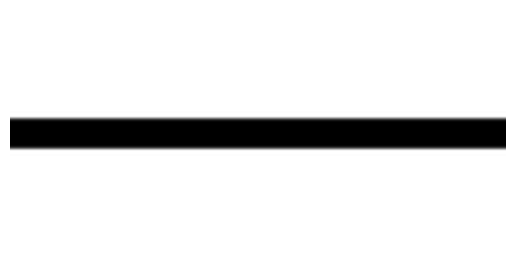

In [8]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')
plt.show()

Getting results

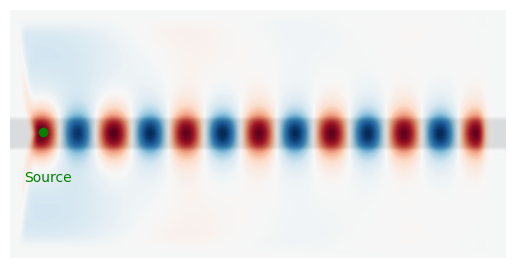

In [9]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.plot(10,39,'go')
plt.text(4,55,'Source',color='g')
plt.axis('off')
plt.show()

# 90 Bend

In [42]:
cell = mp.Vector3(16,16,0)
geometry = [mp.Block(mp.Vector3(12,1,mp.inf),
                     center=mp.Vector3(-2.5,-3.5),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(1,12,mp.inf),
                     center=mp.Vector3(3.5,2),
                     material=mp.Medium(epsilon=12))]
pml_layers = [mp.PML(1.0)]
resolution = 10


SrcWavelen = 2*(11**0.5)
SrcWid = 20

sources = [mp.Source(mp.ContinuousSource(wavelength=SrcWavelen, width=SrcWid),
                     component=mp.Ez,
                     center=mp.Vector3(-7,-3.5),
                     size=mp.Vector3(0,1))]

display(Math(f'Source~info:~~~Wavelength = {SrcWavelen:1.4f} μm,~~~ Width:~{SrcWid}μm,~~~Frequency = {(1/SrcWavelen):1.4f}'))

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

<IPython.core.display.Math object>

To calculate the simulation time, the number of time units must be calculated:

$1/f = T$, if $f = 0.15$, then $T \approx 6$. So if we want to simulate 100 periods, then it must have $6 \cdot 100 = 600$ time units. If we want to simulate 0.1 periods, then it must have $6 \cdot 0.1 = 0.6$ time units.

*sim.run()* can have functions inside it, that modifies how to treat data

```at_beggining```**(step function)** forces an output function to execute at the start of the simulation

```at_every``` **(step function)** forces at every timeunit value, to execute an output function

```to_appended``` given zero or more step functions, converts any output function data to a .h5 file


In [43]:
sim.use_output_directory('pngComponents/Bend90') # Will set the output directory at 'pngComponents/Bend90'

sim.run(mp.at_beginning(mp.output_epsilon),   # At the start of the simulation only, output the epsilon
        mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),  # At each 0.6 time units (approx. 0.1 wavelength periods), output Ez
        until=200)

# These additional configurations to sim.run() generates data files, each config generate a single 3d HDF5 file.

-----------
Initializing structure...
time for choose_chunkdivision = 8.70228e-05 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.016747 s
-----------
Meep: using output directory 'pngComponents/Bend90'
creating output file "pngComponents/Bend90/eps-000000.00.h5"...
creating output file "pngComponents/Bend90/ez.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


Here, all the Ez plots are condensed in a h5 file. Using the *h5ls* command below, one can see it shape

In [44]:
!h5ls pngComponents/Bend90/ez.h5  # Analyzing contents of HDF5 file

ez                       Dataset {160, 160, 333/Inf}


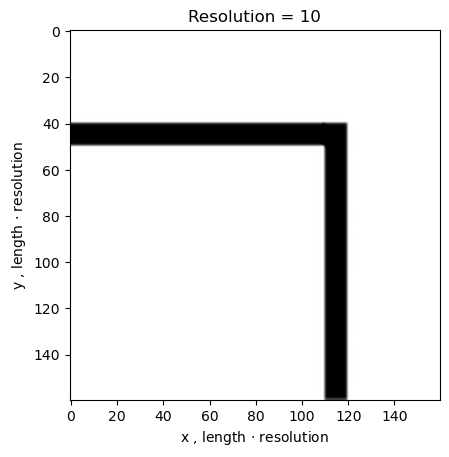

In [45]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(),interpolation='spline36', cmap='binary')
plt.axis('on')
plt.xlabel('x , length $\cdot$ resolution')
plt.ylabel('y , length $\cdot$ resolution')
plt.title(f'Resolution = {resolution}')
plt.show()

In [46]:
# Converts h5 file into gif
!h5topng -t 0:332-R -Zc dkbluered -a yarg -A pngComponents/Bend90/eps-000000.00.h5 pngComponents/Bend90/ez.h5 # h5 to png
!convert pngComponents/Bend90/ez.t*.png pngComponents/Bend90/ez.gif # png to gif
!rm pngComponents/Bend90/ez.t*.png # png removal

!rm pngComponents/Bend90/eps-000000.00.h5
!rm pngComponents/Bend90/ez.h5

## Slicing in y

The only way to get a iteration loop using meep, is by inserting a function call on a step function.

In this case ```get_slice``` is being called by ```at_every``` every 0.6 timesteps

-----------
Initializing structure...
time for choose_chunkdivision = 0.000115871 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.021013 s
-----------
creating output file "./eps-000000.00.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


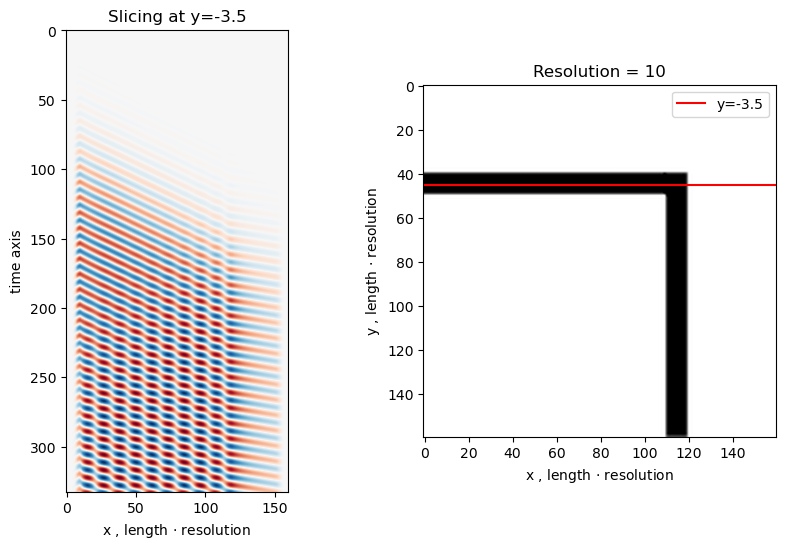

In [65]:
vals = []
yslice = -3.5

def get_slice(sim):
    vals.append(sim.get_array(center=mp.Vector3(0,yslice), size=mp.Vector3(16,0), component=mp.Ez))

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.at_every(0.6, get_slice),
        until=200)

figure,ax=plt.subplots(1, 2,figsize=(10,6))

ax[0].imshow(vals, interpolation='spline36', cmap='RdBu')
ax[0].axis('on')
ax[0].set_ylabel('time axis')
ax[0].set_xlabel('x , length $\cdot$ resolution')
ax[0].set_title(f'Slicing at y={yslice}')

!rm eps-000000.00.h5

eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ax[1].imshow(eps_data.transpose(),interpolation='spline36', cmap='binary')
ax[1].axis('on')
ax[1].set_xlabel('x , length $\cdot$ resolution')
ax[1].set_ylabel('y , length $\cdot$ resolution')
ax[1].set_title(f'Resolution = {resolution}')
ax[1].plot(np.arange(cell[0]*resolution) , np.ones(int(cell[0]*resolution))*(yslice+cell[0]/2)*resolution, color='red', label=f'y={yslice}')
ax[1].legend()

datapath = 'pngComponents/Bend90'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Slice at y=" + str(yslice) + ".png", transparent=False, facecolor="white", bbox_inches="tight")

one can use ```in_volume``` function to obtain the same slice

In [47]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

sim.use_output_directory('pngComponents/Bend90')
sim.run(mp.in_volume(mp.Volume(mp.Vector3(0,-3.5), size=mp.Vector3(16,0)), mp.to_appended("ez-slice" , mp.at_every(0.6, mp.output_efield_z))), until=200)

!h5topng -Zc dkbluered -a yarg pngComponents/Bend90/ez-slice.h5
!rm pngComponents/Bend90/ez-slice.h5
        

-----------
Initializing structure...
time for choose_chunkdivision = 0.000118971 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.016655 s
-----------
Meep: using output directory 'pngComponents/Bend90'
creating output file "pngComponents/Bend90/ez-slice.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


# Transmitance spectrum

In [114]:
resolution = 10 # pixels/um

sx = 16  # size of cell in X direction
sy = 32  # size of cell in Y direction
cell = mp.Vector3(sx,sy,0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

pad = 4  # padding distance between waveguide and cell edge
w = 1    # width of waveguide

wvg_xcen =  0.5*(sx-w-2*pad)  # x center of horiz. wvg
wvg_ycen = -0.5*(sy-w-2*pad)  # y center of vert. wvg

geometry = [mp.Block(size=mp.Vector3(mp.inf,w,mp.inf),
                     center=mp.Vector3(0,wvg_ycen,0),
                     material=mp.Medium(epsilon=12))]

fcen = 0.15  # pulse center frequency
df = 0.1     # pulse width (in frequency)
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
                     size=mp.Vector3(0,w,0))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

After the simulation object was set, we have to specify where we want Meep to compute the flux spectra, and at what frequencies. This is because all of the field parameters are initialized when flux planes are created

In [115]:
nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

display(Math(f'Reflected~Flux~region:~~Center=({-0.5*sx+dpml+0.5},{wvg_ycen},0)~~~|~~~Size=(0,{2*w},0)'))
display(Math(f'Transmitted~Flux~region:~~Center=({0.5*sx-dpml},{wvg_ycen},0)~~~|~~~Size=(0,{2*w},0)'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

To normalize the transmitance spectrum, **two runs must be done**: one for a straight waveguide, and another with the bend, subtracted with the first run results

## First run

We need to keep running after the source has turned off because we must give the pulse time to propagate completely across the cell. Therefore, it is convenient to specify the run time by using ```stop_when_fields_decayed```, which in this case, will stop only when Ez decays to 0.001 its initial value at measured point *pt*.

-----------
Initializing structure...
time for choose_chunkdivision = 0.000211954 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.030565 s
-----------
creating output file "./eps-000000.00.h5"...
field decay(t = 50.050000000000004): 4.825189380557793e-09 / 4.825189380557793e-09 = 1.0
field decay(t = 100.05000000000001): 0.0288018098794258 / 0.0288018098794258 = 1.0
field decay(t = 150.1): 0.026893465093385728 / 0.0288018098794258 = 0.933742192104279
field decay(t = 200.15): 2.3158397323771355e-13 / 0.0288018098794258 = 8.040604885845821e-12
run 0 finished at t = 200.15 (4003 timesteps)


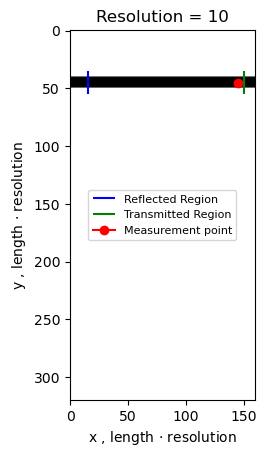

In [116]:
pt = mp.Vector3(0.5*sx-dpml-0.5,wvg_ycen)

sim.run(mp.at_beginning(mp.output_epsilon) , until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

!rm eps-000000.00.h5

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(),interpolation='spline36', cmap='binary')
plt.vlines((-0.5*sx+dpml+0.5 + sx/2)*resolution , (wvg_ycen+sy/2-w)*resolution , (wvg_ycen+sy/2+w)*resolution , label = 'Reflected Region', color='blue')
plt.vlines((0.5*sx-dpml + sx/2)*resolution , (wvg_ycen+sy/2-w)*resolution , (wvg_ycen+sy/2+w)*resolution , label = 'Transmitted Region', color='green')
plt.plot((0.5*sx-dpml-0.5 + sx/2)*resolution , (wvg_ycen+sy/2)*resolution, '-o' , color='red', label='Measurement point')
plt.axis('on')
plt.xlabel('x , length $\cdot$ resolution')
plt.ylabel('y , length $\cdot$ resolution')
plt.title(f'Resolution = {resolution}')
plt.legend(loc='center',fontsize=8)
plt.show()

## Second run

-----------
Initializing structure...
time for choose_chunkdivision = 9.29832e-05 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0320241 s
-----------
field decay(t = 50.050000000000004): 1.6976522694449004e-10 / 1.6976522694449004e-10 = 1.0
field decay(t = 100.05000000000001): 4.6910710639105397e-07 / 4.6910710639105397e-07 = 1.0
field decay(t = 150.1): 2.9928727336863423e-07 / 4.6910710639105397e-07 = 0.6379934758846828
field decay(t = 200.15): 0.003927813565272273 / 0.003927813565272273 = 1.0
field decay(t = 250.20000000000002): 0.00015009081939074004 / 0.003927813565272273 = 0.03821230740627982
field decay(

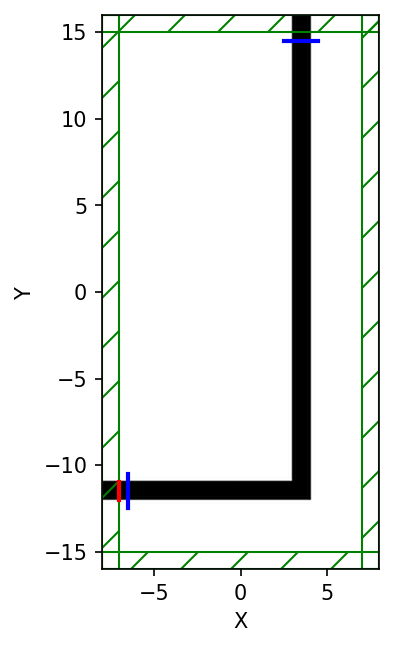

In [109]:
sim.reset_meep()  # Resets the structure and fields

geometry = [mp.Block(mp.Vector3(sx-pad,w,mp.inf), center=mp.Vector3(-0.5*pad,wvg_ycen), material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(w,sy-pad,mp.inf), center=mp.Vector3(wvg_xcen,0.5*pad), material=mp.Medium(epsilon=12))]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(center=mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5,0), size=mp.Vector3(2*w,0,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(wvg_xcen,0.5*sy-dpml-0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

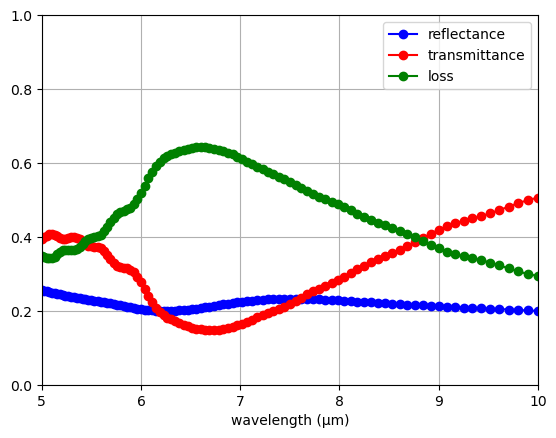

In [107]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])
    Ts = np.append(Ts,bend_tran_flux[i]/straight_tran_flux[i])

plt.figure()
plt.plot(wl,Rs,'bo-',label='reflectance')
plt.plot(wl,Ts,'ro-',label='transmittance')
plt.plot(wl,1-Rs-Ts,'go-',label='loss')
plt.axis([5.0, 10.0, 0, 1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.grid()
plt.show()